<a class="anchor" id="0.1"></a>
# **Table of Contents**
1. [Introduction](#1)
2. [Business Understanding](#2)
3. [Data Understanding](#3)
4. [Data Preperation](#4)
5. [Modeling](#5)
6. [Evaluation](#6)

# **1. Introduction** <a class="anchor" id="1"></a>
[Table of Contents](#0.1)

This notebook will explore Feedforward Neural Networks by going through the CRISP-DM process. The goal is to gain insight into how to use FNN in Python.

### Feedforward Neural Networks

Feedforward Neural Networks (FNNs) are a type of neural network where the connection between nodes do not form any cycle. Information moves forward, from the input nodes, through the hidden nodes, to the output nodes. The following is the typical process of a FNN:

**1. Forward Pass**

Input data is fed into the input layer. Each neuron passes its signal forward to all neurons in the hidden layer. Each connection between neurons has an associated weight that determines the strength of the connection.

**2. Activation Function**

At each neuron in the hidden layer, the weighed sum of inputs is calculated, and then an activation function is applied. Common activation functions include sigmoid, tanh, and ReLU (Rectified Linear Unit).

**3. Propagation**

The output of each neuron becomes the input of the neurons in the next layer. This process continues until the output layer is reached.

**4. Output**

The output layer represents the predictions or classifications made by the neural network based on the input data.

**5. Error Calculation and Backpropagation**

The network's output is compared to the actual actual target value, and the error is calculated.

# **2. Business Understanding** <a class="anchor" id="2"></a>
[Table of Contents](#0.1)

The dataset I will be using for this notebook is the [Phishing Url](https://www.kaggle.com/datasets/hemanthpingali/phishing-url?resource=download). I will be attempting to train a neural network to identify phishing urls.

The dataset contains various features extracted from the urls including length, presence of elements (IP, TLDs), content-related attributes, technical indicators, and others. Altogether there are 87 such attributes in the dataset.


# **3. Data Understanding** <a class="anchor" id="3"></a>
[Table of Contents](#0.1)

We will now explore our dataset to understand the data we are working with. Our data is stored in a .parquet file, so we'll want to convert it to a .csv file.

In [29]:
# This library will help us access our file
try:
    import os
except:
    !pip install os
    import os
    
# This library is for data processing, and file I/O
try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd

In [30]:
current_working_directory = os.getcwd()
file = r'\input\phishingURL.parquet' #this directory may differ for you
data = current_working_directory + file

# convert to a csv
df = pd.read_parquet(data)
df.to_csv(current_working_directory + r'\input\phishingURL.csv') 

# read the new csv
data = current_working_directory + r'\input\phishingURL.csv'
df = pd.read_csv(data)

In [31]:
df.shape

(3772, 90)

We can see that there are 3772 instances, and 90 attributes, which is more than what we were expecting from business understanding. Let's look at the columns and determine what we are working with.

In [32]:
df.head()

,Unnamed: 0,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,0,https://clubedemilhagem.com/home.php,36,19,0,2,0,0,0,0,...,1,0,0,344,21,0,0,1,0,phishing
1,1,http://www.medicalnewstoday.com/articles/18893...,51,24,0,3,0,0,0,0,...,1,1,0,103,6106,737,0,1,6,legitimate
2,2,https://en.wikipedia.org/wiki/NBC_Nightly_News,46,16,0,2,0,0,0,0,...,0,1,0,901,7134,12,0,0,7,legitimate
3,3,http://secure.web894.com/customer_center/custo...,185,17,1,2,1,0,1,2,...,1,1,0,247,1944,0,0,1,0,phishing
4,4,https://en.wikipedia.org/wiki/Transaction_proc...,52,16,0,2,0,0,0,0,...,0,1,0,901,7134,12,0,0,7,legitimate


Here we can see that from our 90 columns, two are indices (first and second), and the third is the url, meaning that the remaining 87 columns match our expected attributes. We can drop the extra indice column during our data preperation phase, since they won't be necessary to train our model. We can also drop the url column, as the rest of the attributes are data about the url, which is what we want to use to make our prediction.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 90 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  3772 non-null   int64  
 1   url                         3772 non-null   object 
 2   length_url                  3772 non-null   int64  
 3   length_hostname             3772 non-null   int64  
 4   ip                          3772 non-null   int64  
 5   nb_dots                     3772 non-null   int64  
 6   nb_hyphens                  3772 non-null   int64  
 7   nb_at                       3772 non-null   int64  
 8   nb_qm                       3772 non-null   int64  
 9   nb_and                      3772 non-null   int64  
 10  nb_or                       3772 non-null   int64  
 11  nb_eq                       3772 non-null   int64  
 12  nb_underscore               3772 non-null   int64  
 13  nb_tilde                    3772 

Here we can see that we have no missing values for our 3772 records.

### Explore Categorical Variables

In [34]:
# identify categorical variables

categorical = [var for var in df.columns if df[var].dtype=='O']

print(f'There are {len(categorical)} categorical variables\n')
print(f'The categorical variables are: {categorical}')

There are 2 categorical variables

The categorical variables are: ['url', 'status']


### Explore Numerical Variables

In [35]:
# identify numerical variables

numerical = [var for var in df.columns if df[var].dtype!='O']

print(f'There are {len(numerical)} numerical variables\n')
print(f'The numerical variables are: {numerical}')

There are 88 numerical variables

The numerical variables are: ['Unnamed: 0', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'statistical_report', 'nb_hyperlinks', 'ratio_intHyperli

# **4. Data Preperation** <a class="anchor" id="4"></a>
[Table of Contents](#0.1)

During the Data Understanding phase, we noticed there were some unecessary columns in our dataset. We will drop the first two columns, as they won't helpful for us to train our model.

In [36]:
df.drop(df.columns[:2], inplace=True, axis=1)
df.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,36,19,0,2,0,0,0,0,0,0,...,1,0,0,344,21,0,0,1,0,phishing
1,51,24,0,3,0,0,0,0,0,0,...,1,1,0,103,6106,737,0,1,6,legitimate
2,46,16,0,2,0,0,0,0,0,0,...,0,1,0,901,7134,12,0,0,7,legitimate
3,185,17,1,2,1,0,1,2,0,3,...,1,1,0,247,1944,0,0,1,0,phishing
4,52,16,0,2,0,0,0,0,0,0,...,0,1,0,901,7134,12,0,0,7,legitimate


Now we want to extract our target variable from the dataset.

In [37]:
target_variable = 'status'

X_target = df.drop([target_variable], axis=1)

y = df[target_variable]
df.drop([target_variable], inplace=True, axis=1)

Next we want to scale our values to ensure all attributes contribute equally to the model's training.

In [38]:
try:
    from sklearn.preprocessing import StandardScaler
except:
    !pip install sklearn
    from sklearn.preprocessing import StandardScaler

In [39]:
df

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,36,19,0,2,0,0,0,0,0,0,...,0,1,0,0,344,21,0,0,1,0
1,51,24,0,3,0,0,0,0,0,0,...,0,1,1,0,103,6106,737,0,1,6
2,46,16,0,2,0,0,0,0,0,0,...,0,0,1,0,901,7134,12,0,0,7
3,185,17,1,2,1,0,1,2,0,3,...,0,1,1,0,247,1944,0,0,1,0
4,52,16,0,2,0,0,0,0,0,0,...,0,0,1,0,901,7134,12,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,34,26,0,2,0,0,0,0,0,0,...,0,0,0,0,373,6202,7701846,0,0,5
3768,54,14,0,2,0,0,0,0,0,0,...,0,1,1,0,139,6071,14420,0,0,5
3769,25,16,0,2,0,0,0,0,0,0,...,0,0,0,0,238,5971,402341,0,0,3
3770,550,25,1,5,24,0,1,9,0,10,...,0,1,1,0,349,6591,30,0,1,4


In [40]:
scaler = StandardScaler()
X = scaler.fit_transform(df)
df_scaled = pd.DataFrame(data=X, columns=df.columns)
df_scaled.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,-0.530043,-0.192143,-0.428870,-0.374353,-0.458789,-0.151506,-0.384054,-0.211981,0.0,-0.307427,...,-0.37083,0.545898,-0.890858,-0.27377,-0.200046,-1.303867,-0.427241,-0.135494,0.917005,-1.255602
1,-0.216023,0.229918,-0.428870,0.365720,-0.458789,-0.151506,-0.384054,-0.211981,0.0,-0.307427,...,-0.37083,0.545898,1.122513,-0.27377,-0.538596,0.650155,-0.426863,-0.135494,0.917005,1.119788
2,-0.320696,-0.445380,-0.428870,-0.374353,-0.458789,-0.151506,-0.384054,-0.211981,0.0,-0.307427,...,-0.37083,-1.831846,1.122513,-0.27377,0.582413,0.980268,-0.427235,-0.135494,-1.090507,1.515686
3,2.589220,-0.360967,2.331708,-0.374353,0.006538,-0.151506,2.391141,2.310396,0.0,2.843696,...,-0.37083,0.545898,1.122513,-0.27377,-0.336309,-0.686351,-0.427241,-0.135494,0.917005,-1.255602
4,-0.195088,-0.445380,-0.428870,-0.374353,-0.458789,-0.151506,-0.384054,-0.211981,0.0,-0.307427,...,-0.37083,-1.831846,1.122513,-0.27377,0.582413,0.980268,-0.427235,-0.135494,-1.090507,1.515686


Now that our data is scaled, we want to split our dataset into a training and testing set. Our testing set will allow us to test our model's accuracy.

In [41]:
try:
    from sklearn.model_selection import train_test_split
except:
    !pip install sklearn
    from sklearn.model_selection import train_test_split
    
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

In [42]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

# encode the training sets
y_train = (y_train == 'legitimate').astype(int)
y_test = (y_test == 'legitimate').astype(int)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2640, 87) (2640,)
Test set: (1132, 87) (1132,)


# **5. Modeling** <a class="anchor" id="5"></a>
[Table of Contents](#0.1)

Our data is ready to train our model. In this notebook, we will be using tenserflow to train our model. Neural Network models consists of an input layer, hidden layer, and output layer. We will define each layer, and add them to our model.

In [43]:
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
except:
    !pip install tensorflow
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense

In [44]:
fnn_model = Sequential()

# input layer neruons count equal to number of features and ReLU activation
input_layer = Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu')

# hidden layer with 64 neurons for the first, and 32 for the second, and ReLU activation
hidden_layer_one = Dense(64, activation = 'relu')
hidden_layer_two = Dense(32, activation = 'relu')

# output layer with 1 neuron and sigmoid activation (binary classification)
output_layer = Dense(1, activation='sigmoid')

# add the layers to the model
fnn_model.add(input_layer)
fnn_model.add(hidden_layer_one)
fnn_model.add(hidden_layer_two)
fnn_model.add(output_layer)

# compile the model
fnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\alexa\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
# train the model
fnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7272 - loss: 0.5493 - val_accuracy: 0.9276 - val_loss: 0.1861
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.9472 - loss: 0.1527 - val_accuracy: 0.9390 - val_loss: 0.1461
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.9624 - loss: 0.1207 - val_accuracy: 0.9417 - val_loss: 0.1359
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.9652 - loss: 0.0956 - val_accuracy: 0.9417 - val_loss: 0.1377
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.9793 - loss: 0.0761 - val_accuracy: 0.9426 - val_loss: 0.1440
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.9752 - loss: 0.0757 - val_accuracy: 0.9479 - val_loss: 0.1346
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9788 - loss: 0.0597 - val_accuracy: 0.9496 - val_loss: 0.1383
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.9841 - loss: 0.0445 - val_accuracy: 0.9443

# **6. Evaluation** <a class="anchor" id="6"></a>
[Table of Contents](#0.1)

In [56]:
try:
    from sklearn.metrics import accuracy_score
except:
    !pip install sklearn
    from sklearn.metrics import accuracy_score

y_pred_train = fnn_model.predict(X_train)
y_pred_train = (y_pred_train >= 0.5).astype(int) # round probabilities to get binary labels
    
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
Model accuracy score: 0.9470
Training-set accuracy score: 0.9947


The trainin-set accuracy score is 0.9440 while the test-set accuracy is 0.9947. The two values differ by about 5%, which indicates there is little overfitting in the model.

In [59]:
# return the most frequent value
most_frequent = (y_test == 0).sum() if (y_test == 0).sum() >= (y_test == 1).sum() else (y_test == 1).sum()

null_accuracy = most_frequent/len(y_test)
print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.5044


Our model accuracy score is 0.9470 while our null accuracy is 0.5044. Having a model accuracy score that is higher than the null accuracy is indicative that our model is doing a good job at predicting the classes.

### Confusion matrix

A confusion matrix is a tool for summarizing the performance of a classification algorithm. A confusion matrix will give us a clear picture of classification model performance and the types of errors produced by the model. It gives us a summary of correct and incorrect predictions broken down by each category. The summary is represented in a tabular form.


Four types of outcomes are possible while evaluating a classification model performance. These four outcomes are described below:-


**True Positives (TP)** – True Positives occur when we predict an observation belongs to a certain class and the observation actually belongs to that class.


**True Negatives (TN)** – True Negatives occur when we predict an observation does not belong to a certain class and the observation actually does not belong to that class.


**False Positives (FP)** – False Positives occur when we predict an observation belongs to a    certain class but the observation actually does not belong to that class. This type of error is called **Type I error.**



**False Negatives (FN)** – False Negatives occur when we predict an observation does not belong to a certain class but the observation actually belongs to that class. This is a very serious error and it is called **Type II error.**



These four outcomes are summarized in a confusion matrix given below.

#### from Phrashant Banerjee [Naive Bayes Classifier in Python](https://www.kaggle.com/code/prashant111/naive-bayes-classifier-in-python)

In [46]:
loss, accuracy = fnn_model.evaluate(X_test, y_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.9479 - loss: 0.1821


In [47]:
try:
    from sklearn.metrics import confusion_matrix
except:
    !pip install sklearn
    from sklearn.metrics import confusion_matrix

In [60]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[545  16]
 [ 44 527]]

True Positives(TP) =  545

True Negatives(TN) =  527

False Positives(FP) =  16

False Negatives(FN) =  44


The confusion matrix shows `545 + 527 = 1072 correct predictions` and `16 + 44 = 60 incorrect predictions`.


In this case, we have


- `True Positives` (Actual Positive:1 and Predict Positive:1) - 545


- `True Negatives` (Actual Negative:0 and Predict Negative:0) - 527


- `False Positives` (Actual Negative:0 but Predict Positive:1) - 16 `(Type I error)`


- `False Negatives` (Actual Positive:1 but Predict Negative:0) - 44 `(Type II error)`

<AxesSubplot:>

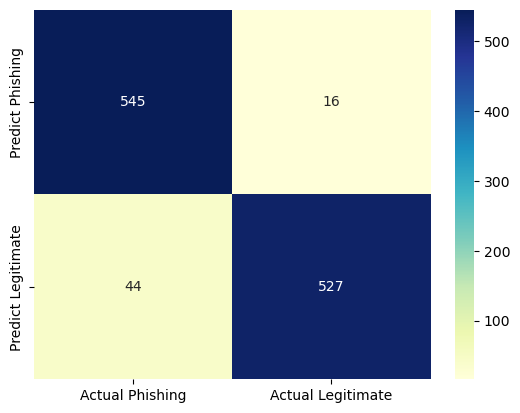

In [61]:
# visualize confusion matrix with seaborn heatmap

try:
    import seaborn as sns # for statistical data visualization
except:
    !pip install seaborn
    import seaborn as sns # for statistical data visualization


cm_matrix = pd.DataFrame(data=cm, columns=['Actual Phishing', 'Actual Legitimate'], 
                                 index=['Predict Phishing', 'Predict Legitimate'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### Classification Report


**Classification report** is another way to evaluate the classification model performance. It displays the  **precision**, **recall**, **f1** and **support** scores for the model.

We can print a classification report as follows:-
#### from Phrashant Banerjee [Naive Bayes Classifier in Python](https://www.kaggle.com/code/prashant111/naive-bayes-classifier-in-python)

In [62]:
try:
    from sklearn.metrics import classification_report
except:
    !pip install sklearn
    from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       561
           1       0.97      0.92      0.95       571

    accuracy                           0.95      1132
   macro avg       0.95      0.95      0.95      1132
weighted avg       0.95      0.95      0.95      1132



### Accuracy
**Accuracy** measures the overall correctness of the predictions. It is a general indicator of how well the model is performing.

Mathematically, accuracy can be defined as the ratio of `(TP + FP) to (TP + FP + FN + TN)`

### Precision


**Precision** can be defined as the percentage of correctly predicted positive outcomes out of all the predicted positive outcomes. It can be given as the ratio of true positives (TP) to the sum of true and false positives (TP + FP). 


So, **Precision** identifies the proportion of correctly predicted positive outcome. It is more concerned with the positive class than the negative class.



Mathematically, precision can be defined as the ratio of `TP to (TP + FP)`.
#### from Phrashant Banerjee [Naive Bayes Classifier in Python](https://www.kaggle.com/code/prashant111/naive-bayes-classifier-in-python)

### Recall


Recall can be defined as the percentage of correctly predicted positive outcomes out of all the actual positive outcomes.
It can be given as the ratio of true positives (TP) to the sum of true positives and false negatives (TP + FN). **Recall** is also called **Sensitivity**.


**Recall** identifies the proportion of correctly predicted actual positives.


Mathematically, recall can be given as the ratio of `TP to (TP + FN)`.
#### from Phrashant Banerjee [Naive Bayes Classifier in Python](https://www.kaggle.com/code/prashant111/naive-bayes-classifier-in-python)

### Specificity

**Specificity** represents the propertion of correctly identified actual negatives. It helps us understand how well the model can idenitfy instances that don't belong the the positive class. High specificity is indicative that the model is good at avoiding false positives. Low specificity is indicative that the model is misclassifying negative instances as positive.

Mathematically, specificity can be given as the ratio of `TN to (TN + FP)`

### Negative Predictive Value (NPV)
**NPV** asses the likelihood that a negative prediction is correct. High NPV indicates the model is correctly idenitfying true negatives. Low NPV indicates the model is missclassifying negative instances.

Mathematically, NPV can be given as the ratio of `TN to (TN + FN)`

### f1-score


**f1-score** is the weighted harmonic mean of precision and recall. The best possible **f1-score** would be 1.0 and the worst 
would be 0.0.  **f1-score** is the harmonic mean of precision and recall. So, **f1-score** is always lower than accuracy measures as they embed precision and recall into their computation. The weighted average of `f1-score` should be used to 
compare classifier models, not global accuracy.

Mathematically, f1-score can be given by the following formula: `2 x (Percision x Recall)/(Precision + Recall)`

#### from Phrashant Banerjee [Naive Bayes Classifier in Python](https://www.kaggle.com/code/prashant111/naive-bayes-classifier-in-python)

In [63]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
specificity = TN / (TN + FP)
negative_predictive_value = TN / (TN + FN)
accuracy = (TP + TN) / float(TP + TN + FP + FN)
f1_score = 2*((precision * recall) / (precision + recall))
balanced_accuracy = (recall + specificity) / 2

print('Accuracy : {0:0.4f}'.format(accuracy))
print('Precision : {0:0.4f}'.format(precision))
print('Recall: {0:0.4f}'.format(recall))
print('Specificity : {0:0.4f}'.format(specificity))
print('NPV: {0:0.4f}'.format(negative_predictive_value))
print('F1 Score: {0:0.4f}'.format(f1_score))
print('Balanced Accuracy: {0:0.4f}'.format(balanced_accuracy))

Accuracy : 0.9470
Precision : 0.9715
Recall: 0.9253
Specificity : 0.9705
NPV: 0.9229
F1 Score: 0.9478
Balanced Accuracy: 0.9479


# **7. Improvements** <a class="anchor" id="7"></a>
[Table of Contents](#0.1)

Now that we've evaluated our model, we can reflect on our result and see if there are any improvements to be made.

Given our results of `94.7%`, we can conclude that our model is exceedingly well trained to accurately predicts if urls are legitimate or phishing. From this point forward, our goal would be to try and train the model on fewer attributes to see if we can maintain accuracy with less data. 87 attributes is a lot of attributes to make predictions, and it would be more useful for our use-case to reduce the number of attributes, especially if we can maintain a high level of accuracy.